In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from src.ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import concatenate

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCnn_Feit-reduced-rgb-no-inception-no-pooling"


OSError: cannot load library 'libvips.so.42': /lib/x86_64-linux-gnu/librsvg-2.so.2: undefined symbol: cairo_tag_end.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libvips.so.42'

In [2]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        lr_schedule = schedules.ExponentialDecay(
            initial_learning_rate=1e-2,
            decay_steps=30,
            decay_rate=0.1,
            staircase=True)

        self.optimizer = Adam(
            learning_rate=lr_schedule,
            beta_1=0.99,
            beta_2=0.9999)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = keras.layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=5, strides=(2, 2), padding='same')(inputs)

        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=5, strides=(2, 2), padding='same')(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=12, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [3]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 128, 128, 6)       156       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 6)       24        
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 64, 64, 12)        312       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 12)        48        
_________________________________________________________________
depthwise_conv2d_2 (Depthwis (None, 32, 32, 24)        624       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 

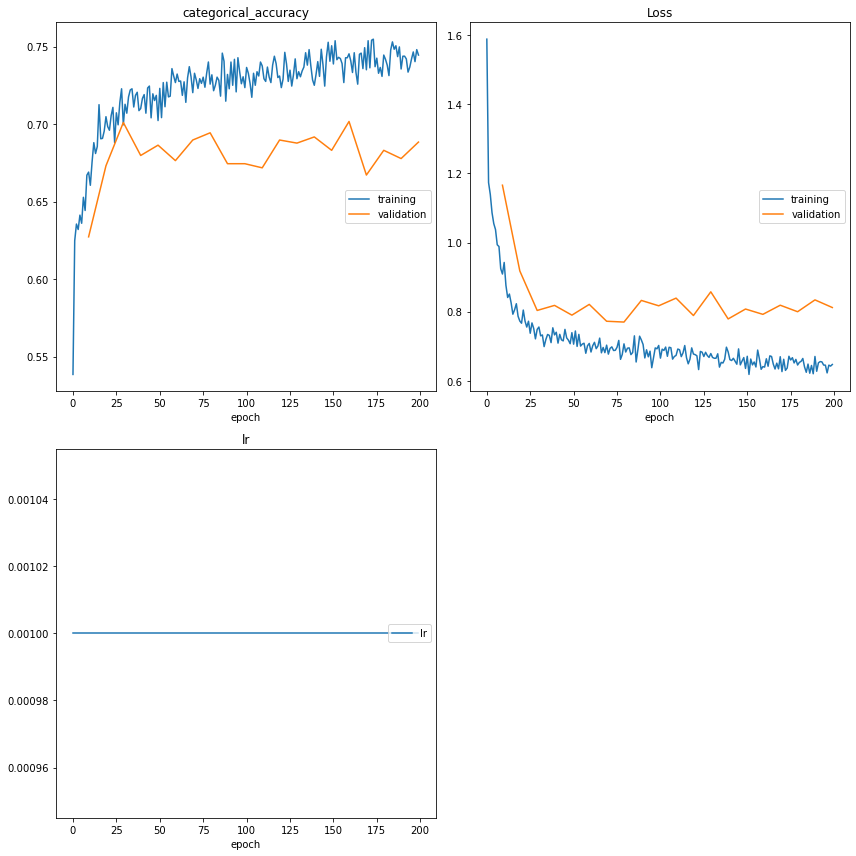

categorical_accuracy
	training         	 (min:    0.539, max:    0.755, cur:    0.744)
	validation       	 (min:    0.627, max:    0.702, cur:    0.688)
Loss
	training         	 (min:    0.619, max:    1.588, cur:    0.647)
	validation       	 (min:    0.770, max:    1.166, cur:    0.812)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
95/95 [==============================] - 5s 50ms/step - loss: 0.8120 - categorical_accuracy: 0.6884
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.3218ms
Confusion Matrix
[[227   0  25   0  10   0   6   4   0   0  63   0]
 [  1  27  24   0   2   0   8   0   0   0   2   0]
 [ 29  11  53   0   3   0  24   4   0   0  21   0]
 [  0   0   0   9   2   0   0   0   0   0   0   0]
 [  0   2   2   1 533   0   0   0   0   0   6   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0]
 [ 28   7  17   0   0   0  11  11   0   0   3   0]
 [  2   0   4   0   0   0   7  73   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   

In [4]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [5]:
pipeline.save_pipeline()

In [6]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1505 images belonging to 12 classes.
95/95 [==============================] - 5s 49ms/step - loss: 0.8120 - categorical_accuracy: 0.6884
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.3389ms
Confusion Matrix
[[227   0  25   0  10   0   6   4   0   0  63   0]
 [  1  27  24   0   2   0   8   0   0   0   2   0]
 [ 29  11  53   0   3   0  24   4   0   0  21   0]
 [  0   0   0   9   2   0   0   0   0   0   0   0]
 [  0   2   2   1 533   0   0   0   0   0   6   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0]
 [ 28   7  17   0   0   0  11  11   0   0   3   0]
 [  2   0   4   0   0   0   7  73   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0]
 [115   1  11   0   4   0   0   0   0   0 103   0]
 [  0   0   0   0   2   0   0   0   0   0   4   0]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.56      0.68      0.62 

In [7]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)